# Práctica Final: Clasificación con Scikit-learn y MLflow

En esta práctica, utilizarás un conjunto de datos de Scikit-learn (podeís usar el mismo que en el notebook de Intro MLFlow) para entrenar un modelo de clasificación.

Pasos a seguir: 

    Exploración de Datos: Analiza el conjunto de datos proporcionado para comprender su estructura y contenido.

    Preprocesamiento de Texto: Realiza tareas de preprocesamiento de texto, como tokenización y vectorización, para preparar los datos para el modelado.

    Entrenamiento del Modelo: Utiliza algoritmos de clasificación de Scikit-learn para entrenar un modelo con los datos preprocesados.

    Evaluación del Modelo: Evalúa el rendimiento del modelo utilizando métricas de evaluación estándar como precisión y recall.

    Registro de Métricas con MLflow: Utiliza MLflow para registrar métricas y hiperparámetros durante el entrenamiento, facilitando la gestión y comparación de experimentos.


Nota: Dado que no voy a poder tener acceso a vuestros logs de MLFlow añadirme las imagenes de la interfaz de MLFlow en el notebook

### Importamos todas las librerías necesarias

In [56]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score


### Exploración del dataset

Para esta práctica, se ha escogido utilizar un dataset de datos sobre los supervivientes del Titanic, de Kaggle: https://www.kaggle.com/datasets/vermaamitesh/titanic-survivor-datasets/data

Tras descargar el zip y obtener el fichero csv con todos los datos, llamado titanic.csv, se ejecuta el siguiente código donde cargamos el dataset y mostramos las columnas del mismo:

In [58]:
# Cargamos el dataset desde el archivo CSV
df = pd.read_csv("titanic.csv")

#Mostramos todas las columnas del dataset
print(df.columns)

# Mostramos las primeras filas
print(df.head())

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
   PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0            1         0       3  ...   7.2500   NaN         S
1            2         1       1  ...  71.2833   C85         C
2            3         1       3  ...   7.9250   NaN         S
3            4         1       1  ...  53.1000  C123         S
4            5         0       3  ...   8.0500   NaN         S

[5 rows x 12 columns]


Las columnas del dataset utilizado para la práctica son las siguientes:

- **PassengerId** → Identificador único de cada pasajero.  
- **Survived** → 0 = No sobrevivió, 1 = Sobrevivió.  
- **Pclass** → Clase del pasajero (1ª, 2ª o 3ª clase).  
- **Name** → Nombre completo del pasajero.  
- **Sex** → Género del pasajero (`male` = hombre, `female` = mujer).  
- **Age** → Edad del pasajero en años.  
- **SibSp** → Número de hermanos o cónyuges a bordo.  
- **Parch** → Número de padres o hijos a bordo.  
- **Ticket** → Número de ticket del pasajero.  
- **Fare** → Precio pagado por el boleto.  
- **Cabin** → Número de cabina (puede estar vacío si no se registró).  
- **Embarked** → Puerto de embarque (`C` = Cherbourg, `Q` = Queenstown, `S` = Southampton).  

Viendo estas columnas, podemos saber que hay algunas que habrá que descartar, ya que no aportarían valor al modelo, como por ejemplo, el passengerId. Sin embargo, hay otras que habrá que tratar o transformar para que puedan ser de valor.

A continuación, vamos a seguir analizando el dataset.

In [59]:
# Información general del dataset
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


Con el resultado anterior podemos ver que el dataset tiene 891 registros y 12 columnas en total. Algunas columnas presentan valores nulos, como Age, que tiene 714 valores no nulos, lo que indica que 177 registros tienen la edad faltante. Cabin es la más incompleta, con solo 204 valores, mientras que Embarked tiene 889 valores, lo que significa que hay 2 datos faltantes en esta columna. 
En cuanto a los tipos de datos, algunas variables son numéricas, como PassengerId, Survived, Pclass, SibSp y Parch, que son enteros, mientras que Age y Fare son de tipo flotante. Otras columnas contienen datos categóricos en formato de texto, como Name, Sex, Ticket, Cabin y Embarked, que necesitarían conversión si se utilizan en modelos de machine learning. 

A continuación, con el uso de describe(include='all') podremos ver información de cada columna, incluyendo variables categóricas, con datos que pueden ayudar a detectar valores atípicos, analizar la distribución de los datos y entender mejor las características del dataset.

In [60]:
# Estadísticas
print(df.describe(include='all'))


        PassengerId    Survived      Pclass  ...        Fare    Cabin  Embarked
count    891.000000  891.000000  891.000000  ...  891.000000      204       889
unique          NaN         NaN         NaN  ...         NaN      147         3
top             NaN         NaN         NaN  ...         NaN  B96 B98         S
freq            NaN         NaN         NaN  ...         NaN        4       644
mean     446.000000    0.383838    2.308642  ...   32.204208      NaN       NaN
std      257.353842    0.486592    0.836071  ...   49.693429      NaN       NaN
min        1.000000    0.000000    1.000000  ...    0.000000      NaN       NaN
25%      223.500000    0.000000    2.000000  ...    7.910400      NaN       NaN
50%      446.000000    0.000000    3.000000  ...   14.454200      NaN       NaN
75%      668.500000    1.000000    3.000000  ...   31.000000      NaN       NaN
max      891.000000    1.000000    3.000000  ...  512.329200      NaN       NaN

[11 rows x 12 columns]


A continuación, me parece interesante mostrar la distribución de sobrevivientes que hubo en el Titanic.

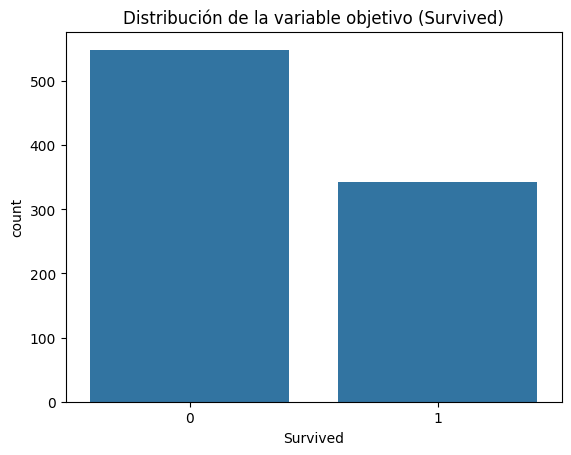

In [61]:
# Distribución de sobrevivientes
sns.countplot(x=df['Survived'])
plt.title("Distribución de la variable objetivo (Survived)")
plt.show()


Ahora, vamos a conocer la distribución de supervivientes por cada una de las clases que había en el Titanic. Sabemos que había 3 clases:  Primera (1), Segunda (2) y Tercera (3).

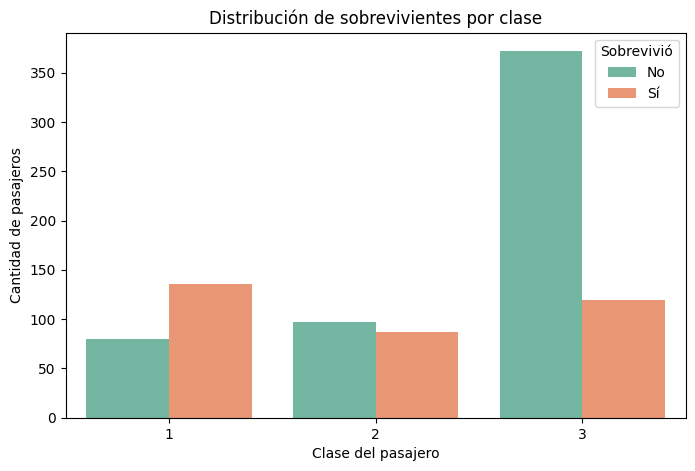

In [62]:
# Gráfico de sobrevivientes por clase
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="Pclass", hue="Survived", palette="Set2")
plt.title("Distribución de sobrevivientes por clase")
plt.xlabel("Clase del pasajero")
plt.ylabel("Cantidad de pasajeros")
plt.legend(title="Sobrevivió", labels=["No", "Sí"])
plt.show()


Con este gráfico podemos saber que, como se esperaba, que la clase con más sobrevivientes fue la primera clase. 

Ahora, vamos a hacer la misma comparativa pero esta vez para mostrar la distribución de edades de los pasajeros del Titanic en relación con su supervivencia. Para ello vamos a usar un histograma con barras diferenciadas por color:
*  Azul: Pasajeros que sobrevivieron.
*  Naranja: Pasajeros que no sobrevivieron.

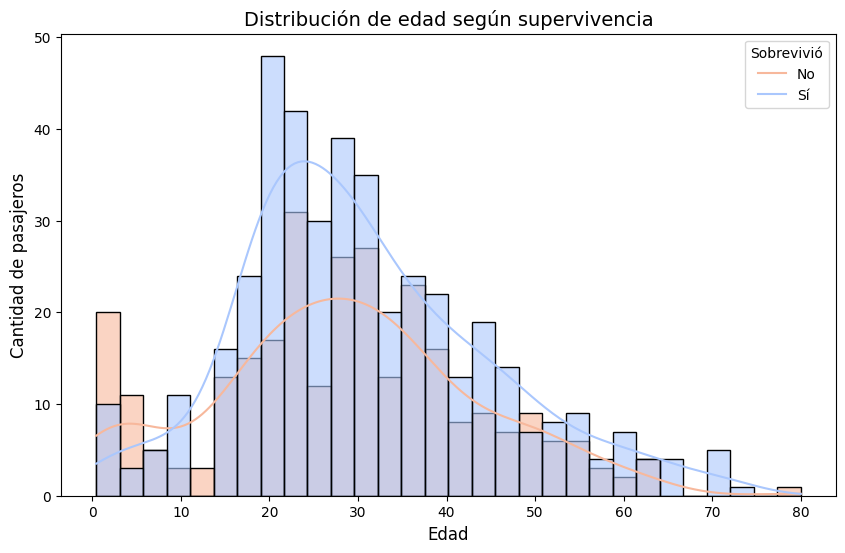

In [63]:
# Configurar el gráfico
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="Age", hue="Survived", bins=30, kde=True, palette="coolwarm", alpha=0.6)

# Etiquetas y título
plt.title("Distribución de edad según supervivencia", fontsize=14)
plt.xlabel("Edad", fontsize=12)
plt.ylabel("Cantidad de pasajeros", fontsize=12)
plt.legend(title="Sobrevivió", labels=["No", "Sí"])

# Mostrar gráfico
plt.show()


Podemos concluir podemos decir que:
*  Niños y supervivencia: Hay una mayor proporción de niños sobrevivientes en comparación con adultos, lo que sugiere que se les dio prioridad en los rescates.
*  Adultos jóvenes: La mayoría de los pasajeros tenían entre 20 y 40 años, pero en este grupo hubo un número significativo de fallecidos.
*  Personas mayores: A medida que aumenta la edad, disminuye la cantidad de sobrevivientes, lo que indica que la supervivencia era menor para los pasajeros de edad avanzada.
*  Tendencia general: Aunque hay supervivientes en casi todos los grupos de edad, los niños y algunos adultos jóvenes tienen más probabilidades de haber sobrevivido en comparación con adultos mayores.


Por último, vamos a comparar el sexo con la supervivencia de personas con el siguiente gráfico:

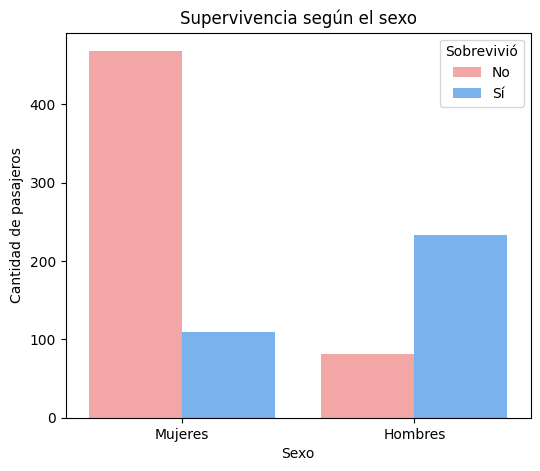

In [64]:
# Crear el gráfico
plt.figure(figsize=(6, 5))
sns.countplot(data=df, x="Sex", hue="Survived", palette=["#FF9999", "#66B2FF"])
plt.title("Supervivencia según el sexo")
plt.xlabel("Sexo")
plt.ylabel("Cantidad de pasajeros")
plt.xticks(ticks=[0, 1], labels=["Mujeres", "Hombres"])
plt.legend(title="Sobrevivió", labels=["No", "Sí"])

# Mostrar el gráfico
plt.show()


Podemos concluir que hubo una mayor cantidad de mujeres que fallecieron frente a los hombres. Sin embargo, esto me parece curioso porque las mujeres y los niños tenían prioridad para subirse a los botes salvavidas.

### División en Train y test

En este apartado, se van a dividir los datos en conjuntos de train y test. Esto es crucial para evaluar el rendimiento del modelo. 
Primero, entrenaremos el modelo con el conjunto de train y lo probaremos con el conjunto de test para ver cómo se comporta con datos no vistos. Esto ayuda a evitar el sobreajuste y asegura que el modelo generalice bien a nuevos datos.
Además, una vez hecha la división, nos quedaremos con el conjunto de train, haremos todos los cambios necesarios, y después, justo antes de entrenar, se harán estos cambios al conjunto de test.

Para esta práctica, el objetivo es entrenar el modelo de clasificación para determinar si una persona o no sobrevivió en el Titanic teniendo en cuenta el resto de variables. Por ello, la variable objetivo es Survived. 0 indica que no, 1 indica que sobrevivió.

In [65]:
# Separamos la variable objetivo
X = df.drop(columns=['Survived'])
y = df['Survived']

# División en 80% train y 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Eliminamos columnas irrelevantes

Ahora vamos a eliminar las columnas innecesarias que no aportan valor.
Estas columnas son los passegnerIds, número de cabina, nombre del pasajero y número de ticket del pasajero.

In [66]:
cols_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
X_train.drop(columns=cols_to_drop, inplace=True)

# Imprimimos número de filas y columnas
num_filas, num_columnas = X_train.shape
print(f"Número de filas: {num_filas}")
print(f"Número de columnas: {num_columnas}")


Número de filas: 712
Número de columnas: 7


#### Manejo valores nulos

Los valores nulos de las variables del dataset hay que tratarlos para que no metan ruido y desvíen los resultados. 
Para ello, primero vamos a conocer cuántas columnas tienen valores nulos:

In [67]:
# Contamos los valores nulos por columna
null_counts = X_train.isnull().sum()

# Filtramos solo aquellas columnas con valores nulos
null_columns = null_counts[null_counts > 0]
print(null_columns)


Age         137
Embarked      2
dtype: int64


Puesto que solo Age y Embarked tienen valores nulos, y no muchos, vamos a rellenar los nulos de Age con la mediana y los de Embarked con la moda.

In [68]:
X_train['Age'].fillna(X_train['Age'].median(), inplace=True)
X_train['Embarked'].fillna(X_train['Embarked'].mode()[0], inplace=True)
X_train.head()

C:\Users\elisa.gutierrez\AppData\Local\Temp\ipykernel_31308\2755802498.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['Age'].fillna(X_train['Age'].median(), inplace=True)
C:\Users\elisa.gutierrez\AppData\Local\Temp\ipykernel_31308\2755802498.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
692,3,male,28.5,0,0,56.4958,S
481,2,male,28.5,0,0,0.0000,S
527,1,male,28.5,0,0,221.7792,S
855,3,female,18.0,0,1,9.3500,S
801,2,female,31.0,1,1,26.2500,S


#### Codificación de los datos

Vamos a codificar la variable Sex, siendo 0 hombre y 1 mujer:

In [69]:
# Convertir "Sex" a binario
X_train['Sex'] = X_train['Sex'].map({'male': 0, 'female': 1})
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
692,3,0,28.5,0,0,56.4958,S
481,2,0,28.5,0,0,0.0000,S
527,1,0,28.5,0,0,221.7792,S
855,3,1,18.0,0,1,9.3500,S
801,2,1,31.0,1,1,26.2500,S


Vamos a codificar la variable Embarked haciendo uso de la función get_dummies(), que convierte valores categóricos en columnas binarias. 

In [70]:
# One-Hot Encoding para "Embarked"
X_train = pd.get_dummies(X_train, columns=['Embarked'], drop_first=True)

A continuación, vamos a agrupar la edad ('Age') en distintas categorías de edad ('Child', 'Young', 'Adult', 'Senior') y codificamos con One-Hot Encoding, creándose una columna binaria nueva por cada grupo de edad. Por ejemplo, si el pasajero tiene 8 años, para el grupo de edad Child, tendrá el valor 1, pero para los otros tres tendrá el valor 0.

In [71]:
# Para Age, creamos una nueva columna 'AgeGroup' basada en los rangos de edad
bins = [0, 18, 25, 65, float('inf')]
labels = ['Child', 'Young', 'Adult', 'Senior']
X_train['AgeGroup'] = pd.cut(X_train['Age'], bins=bins, labels=labels)

# onvertimos cada categoría de 'AgeGroup' en una columna con valores 0 o 1
X_train['Age_Child'] = (X_train['AgeGroup'] == 'Child').astype(int)
X_train['Age_Young'] = (X_train['AgeGroup'] == 'Young').astype(int)
X_train['Age_Adult'] = (X_train['AgeGroup'] == 'Adult').astype(int)
X_train['Age_Senior'] = (X_train['AgeGroup'] == 'Senior').astype(int)

# Eliminamos la columna temporal 'AgeGroup' y la original 'Age'
X_train.drop(columns=['AgeGroup'], inplace=True)
X_train.drop(columns=['Age'], inplace=True)


Por otro lado, en el siguiente código, para las columnas 'SibSp' y 'Parch', he pensado que podemos unirlas en una sola llamada 'HasFamily' e indique con 1 o 0 si el pasajero tenía familia dentro del barco. Para eso se suma el valor de ambas variables y si el resultado es mayor que 0, 'HasFamily' sería 1, sino sería 0.

In [72]:
# Creamos la nueva columna 'HasFamily' y eliminar 'SibSp' y 'Parch'
X_train['HasFamily'] = (X_train['SibSp'] + X_train['Parch'] > 0).astype(int)
X_train.drop(columns=['SibSp', 'Parch'], inplace=True)

# Mostrar las primeras filas del nuevo DataFrame
print(X_train.head())

     Pclass  Sex      Fare  ...  Age_Adult  Age_Senior  HasFamily
692       3    0   56.4958  ...          1           0          0
481       2    0    0.0000  ...          1           0          0
527       1    0  221.7792  ...          1           0          0
855       3    1    9.3500  ...          0           0          1
801       2    1   26.2500  ...          1           0          1

[5 rows x 10 columns]


### Aplicamos todos los cambios en las variables al modelo de test

In [73]:
cols_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
X_test.drop(columns=cols_to_drop, inplace=True)

# Manejo de valores nulos
X_test['Age'].fillna(X_test['Age'].median(), inplace=True)
X_test['Embarked'].fillna(X_test['Embarked'].mode()[0], inplace=True)
X_test.head()

# Convertir "Sex" a binario (0 = male, 1 = female)
X_test['Sex'] = X_test['Sex'].map({'male': 0, 'female': 1})
X_test.head()

# One-Hot Encoding para "Embarked"
X_test = pd.get_dummies(X_test, columns=['Embarked'], drop_first=True)

# 1. Crear una nueva columna 'AgeGroup' basada en los rangos de edad
bins = [0, 18, 25, 65, float('inf')]
labels = ['Child', 'Young', 'Adult', 'Senior']
X_test['AgeGroup'] = pd.cut(X_test['Age'], bins=bins, labels=labels)

# 2. Convertir cada categoría de 'AgeGroup' en una columna con valores 0 o 1
X_test['Age_Child'] = (X_test['AgeGroup'] == 'Child').astype(int)
X_test['Age_Young'] = (X_test['AgeGroup'] == 'Young').astype(int)
X_test['Age_Adult'] = (X_test['AgeGroup'] == 'Adult').astype(int)
X_test['Age_Senior'] = (X_test['AgeGroup'] == 'Senior').astype(int)

# 3. Eliminar la columna original 'AgeGroup'
X_test.drop(columns=['AgeGroup'], inplace=True)
X_test.drop(columns=['Age'], inplace=True)

# 4. Crear la nueva columna 'HasFamily' y eliminar 'SibSp' y 'Parch'
X_test['HasFamily'] = (X_test['SibSp'] + X_test['Parch'] > 0).astype(int)
X_test.drop(columns=['SibSp', 'Parch'], inplace=True)

# Mostrar las primeras filas del nuevo DataFrame
print(X_test.head())


     Pclass  Sex     Fare  ...  Age_Adult  Age_Senior  HasFamily
565       3    0  24.1500  ...          0           0          1
160       3    0  16.1000  ...          1           0          1
553       3    0   7.2250  ...          0           0          0
860       3    0  14.1083  ...          1           0          1
241       3    1  15.5000  ...          1           0          1

[5 rows x 10 columns]


C:\Users\elisa.gutierrez\AppData\Local\Temp\ipykernel_31308\2330186433.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test['Age'].fillna(X_test['Age'].median(), inplace=True)
C:\Users\elisa.gutierrez\AppData\Local\Temp\ipykernel_31308\2330186433.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

Validamos que Test también contiene 10 columnas, al igual que Train.

### Entrenamiento del modelo

En este apartado, entrenamos el modelo. Para ello, vamos a usar la librería MLFlow para loggear todos los resultados.

In [74]:
print(mlflow.get_tracking_uri())


file:///c:/Users/elisa.gutierrez/Documents/Elisa/KeepCoding/DespliegueDeAlgoritmos/mlruns


Con el siguiente código, creamos un experimento en MLFlow llamado Titanic_Survival_Classification, y con start.run ejecutado, entrenamos el modelo y lo evaluamos. Todas las métricas se loggean en MLFlow con 'mlflow.log_param()'.

Para entrenar el modelo, se va a utilizar el algoritmo RandomForestClassifier ya que es una opción excelente para problemas de clasificación como este por su alto rendimiento y su maejo de variables categóricas y numéricas.
Además, también se van a generar dos gráficas: la matriz de confusión y la curva ROC, para representar los resultados. La matriz de confusión nos permite ver cuántos casos se clasificaron correctamente y cuántos fueron falsos positivos o falsos negativos. Por otro lado, la curva ROC muestra el trade-off entre la tasa de verdaderos positivos y la tasa de falsos positivos, permitiendo evaluar qué tan bien el modelo distingue entre clases.

Estos dos gráficos se van a guardar también en MLFlow para ver cómo aparecen en la itnerfaz.

In [ ]:
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Configuramos MLflow
mlflow.set_experiment("Titanic_Survival_Classification")

with mlflow.start_run():
    # Definimos y entrenamos el modelo
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predicciones
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Evaluación del modelo
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Registramos las métricas en MLflow
    mlflow.log_param("n_estimators", 100)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)

    # Guardamos el modelo en MLflow
    mlflow.sklearn.log_model(model, "RandomForestModel")

    print(f"Accuracy: {accuracy:.4f}, Precisión: {precision:.4f}, Recall: {recall:.4f}")

    #Matriz de Confusión 
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No sobrevivió", "Sobrevivió"], yticklabels=["No sobrevivió", "Sobrevivió"])
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión")
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")  # Guardamos en MLflow
    plt.close()

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC")
    plt.legend(loc="lower right")
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")  # Guardamos en MLflow
    plt.close()


El modelo RandomForestClassifier ha sido entrenado y evaluado en el dataset del Titanic, obteniendo los siguientes resultados:

*  Accuracy (0.8045): Mide cuántas predicciones fueron correctas en total. Un 80% indica que el modelo clasifica bien, pero aún tiene margen de mejora.
*  Precisión (0.7576): Indica cuántos de los pasajeros predichos como sobrevivientes realmente sobrevivieron. Es útil cuando la clase positiva es más importante (por ejemplo, si queremos minimizar falsos positivos).
*  Recall (0.7246 ): Mide cuántos de los pasajeros que sobrevivieron fueron correctamente identificados.

Con estos resultaods, podríamos concluir que el modelo tiene buena precisión y un buen balance entre recall y acuracy. 

Si accedemos al puerto 5000 de localhost, podremos acceder a la interfaz de MLFlow y ver los resultados que hemos loggeado, como mostramos en las siguientes imágenes:

*  Métricas obtenidas:
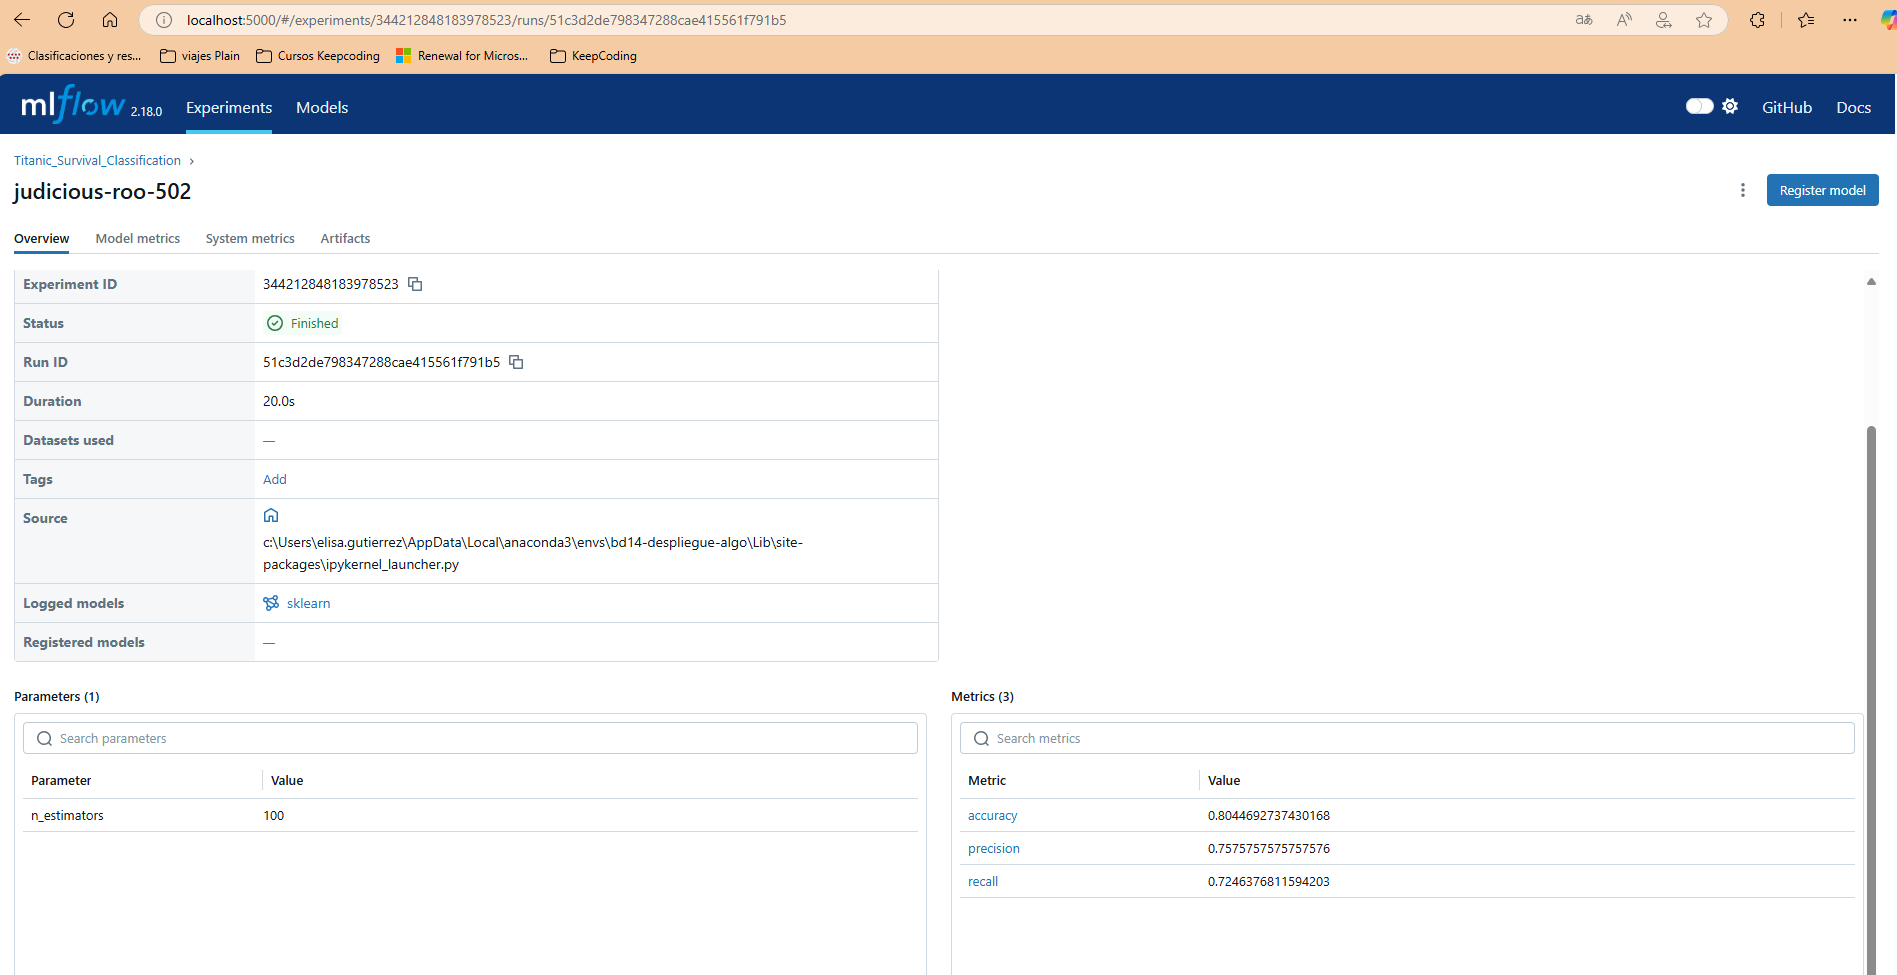

*  Matriz de confusión 
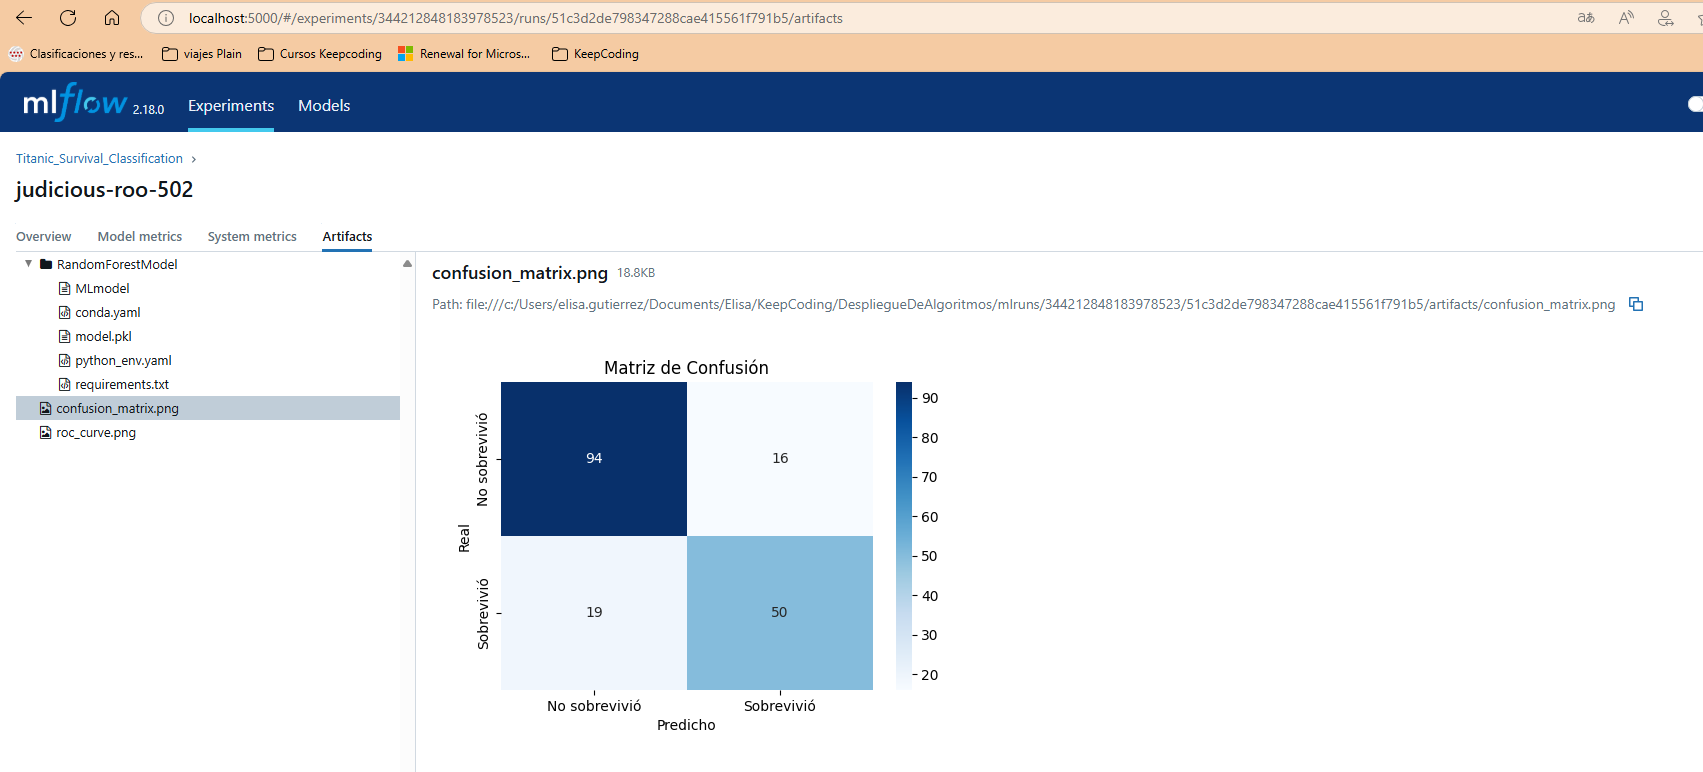

*  Curva ROC
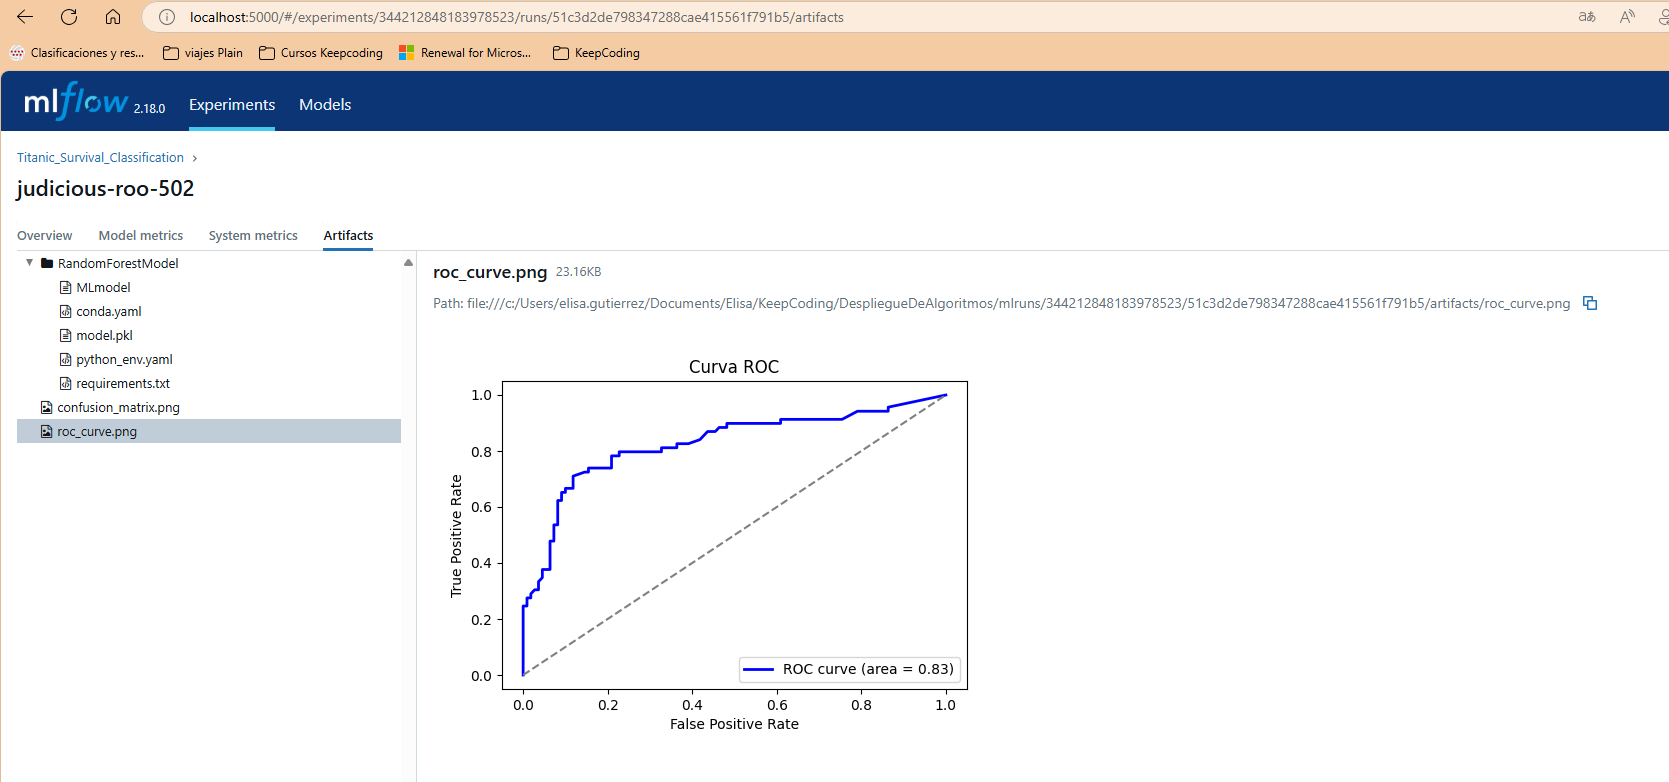

Conclusiones de los resultados mostrados en los gráficos:
*  Matriz de Confusión

    *  Verdaderos negativos (No sobrevivió y predicho como No sobrevivió): 94
    *  Falsos positivos (No sobrevivió pero predicho como Sobrevivió): 16
    *  Falsos negativos (Sobrevivió pero predicho como No sobrevivió): 19
    *  Verdaderos positivos (Sobrevivió y predicho como Sobrevivió): 50
Segúne stos resultados podemos decir que el modelo tiene un buen desempeño, pero hay algunos errores en la predicción de sobrevivientes.


* Curva ROC
    *  Área bajo la curva (AUC): 0.83
Un valor de 0.83 indica que el modelo tiene una buena capacidad de discriminación entre clases, aunque no es perfecto. Un AUC cercano a 1 sería ideal.


POr otro lado, comentar que los resultados se van añadiendo de forma organizada a MLFlow por cada ejecución, creándose experimentos nuevos. Tras probar varias veces, vemos que se han creado varios experimentos distintos:

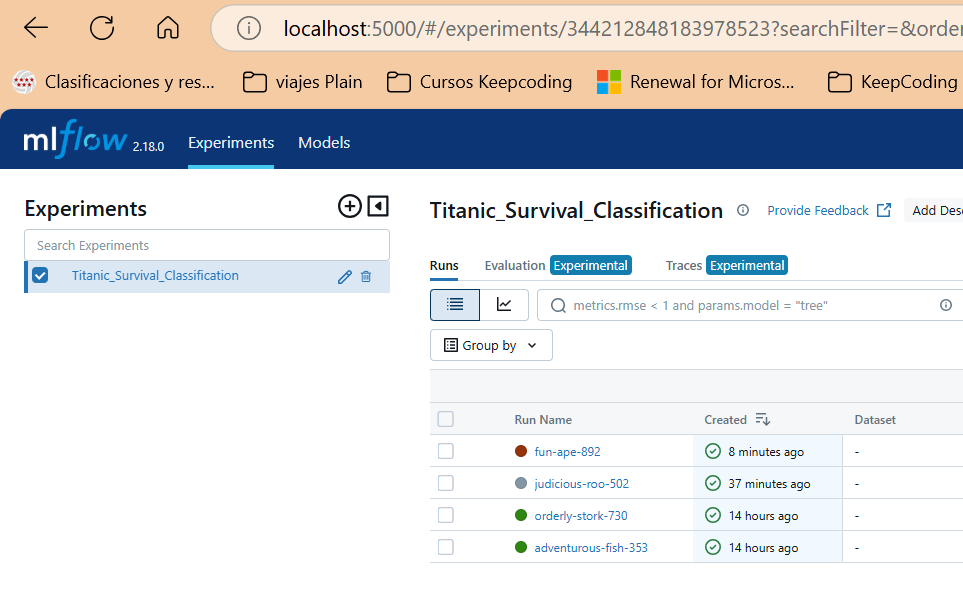

## Generar .py de funciones y main con al menos dos argumentos de entrada.

A continuación, vamos a crear cuatro funciones y a guardarlas en ficheros distintos:
*  Función que divide el dataset original en train y test.
*  Función que procesa el dataset, eliminando colummnas, reemplazando nulls, codificando, etc.
*  Función que entrena y evalúa el modelo.
*  Main, que se encarga de llamar a las distintas funciones con los parámetros necesarios.

In [ ]:
%%writefile split.py
# Función que divide el dataset original en train y test.
import pandas as pd
from sklearn.model_selection import train_test_split

def split_data(csv_path, test_size=0.2):
    """Carga el dataset y lo divide en entrenamiento y prueba."""
    
    # Cargamos los datos
    df = pd.read_csv(csv_path)

    # Separamos la variable objetivo
    X = df.drop(columns=['Survived'])
    y = df['Survived']

    # División en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test


Overwriting split.py


Función que procesa el dataset, eliminando colummnas, reemplazando nulls, codificando, etc:

In [ ]:
%%writefile preprocessing.py
# Procesamos el dataset.
import pandas as pd

def preprocess_data(X):
    """Realiza el preprocesamiento del conjunto de datos Titanic."""

    # Eliminamos columnas irrelevantes
    cols_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    X.drop(columns=cols_to_drop, inplace=True, errors='ignore')

    # Manejamos valores nulos
    X['Age'].fillna(X['Age'].median(), inplace=True)
    X['Embarked'].fillna(X['Embarked'].mode()[0], inplace=True)

    # Convertimos "Sex" a binario (0 = male, 1 = female)
    X['Sex'] = X['Sex'].map({'male': 0, 'female': 1})

    # Aplicamos One-Hot Encoding para "Embarked"
    X = pd.get_dummies(X, columns=['Embarked'], drop_first=True)

    # Creamos una nueva columna 'AgeGroup'
    bins = [0, 18, 25, 65, float('inf')]
    labels = ['Child', 'Young', 'Adult', 'Senior']
    X['AgeGroup'] = pd.cut(X['Age'], bins=bins, labels=labels)

    # Convertimos las categorías de 'AgeGroup' en variables dummy
    X['Age_Child'] = (X['AgeGroup'] == 'Child').astype(int)
    X['Age_Young'] = (X['AgeGroup'] == 'Young').astype(int)
    X['Age_Adult'] = (X['AgeGroup'] == 'Adult').astype(int)
    X['Age_Senior'] = (X['AgeGroup'] == 'Senior').astype(int)

    X.drop(columns=['AgeGroup', 'Age'], inplace=True)

    # Creamos la columna 'HasFamily' y eliminamos 'SibSp' y 'Parch'
    X['HasFamily'] = (X['SibSp'] + X['Parch'] > 0).astype(int)
    X.drop(columns=['SibSp', 'Parch'], inplace=True)

    return X

Overwriting preprocessing.py


Por último, tenemos la función que entrena y evalúa el modelo. EN este caso, he decidido cambiar al algoritmo LogisticRegression, para evaluar los resultados con otro disitnto.

In [ ]:
%%writefile model.py

# Entrenamos y evaluamos el modelo.
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

def train_and_evaluate(X_train, X_test, y_train, y_test):
    """Entrena y evalua un modelo de Logistic Regression."""

    # Configuramos MLflow
    mlflow.set_experiment("Titanic_Survival_Classification")

    with mlflow.start_run():
        # Definimos y entrenamos el modelo
        model = LogisticRegression(random_state=42, max_iter=1000)
        model.fit(X_train, y_train)

        # Generamos predicciones
        y_pred = model.predict(X_test)

        # Evaluamos el modelo
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        # Registramos métricas en MLflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)

        # Guardamos el modelo en MLflow
        mlflow.sklearn.log_model(model, "LogisticRegressionModel")

        print(f"✅ Accuracy: {accuracy:.4f}, Precisión: {precision:.4f}, Recall: {recall:.4f}")


Overwriting model.py


A continuación, tenemos MAIN, que se encarga de recibir los parámetros de entrada y de llamar a las funciones oportunas. En este caso, llama primero a la función que se encarga del split en train y test del dataset cuya ruta recibe main por parámetro. Después, procesa los datos de train llamando a la funcioón preprocess_data con el dataset de train, y a continuación lo mismo para el dataset de test. Por último, entrena y evalúa el modelo, con la función train_and_evaluate.

Los parámetros que main necesita son: 
*  La ruta del csv. 
*  El tamaño en porcentaje del dataset de test, que por defecto es el 20%.
*  Random state para el algoritmo LogisticRegression, que por defecto es 43.

In [86]:
%%writefile main.py
import argparse
import pandas as pd
from split import split_data
from preprocessing import preprocess_data
from model import train_and_evaluate

def main(csv_path, test_size, random_state):
    """Ejecuta el pipeline completo: Split, Preprocesamiento y Entrenamiento."""

    print("📥 Dividiendo los datos en train y test...")
    X_train, X_test, y_train, y_test = split_data(csv_path, test_size)

    print("🔍 Preprocesando los datos de entrenamiento...")
    X_train = preprocess_data(X_train)

    print("🔍 Preprocesando los datos de prueba...")
    X_test = preprocess_data(X_test)

    print("🚀 Entrenando el modelo...")
    train_and_evaluate(X_train, X_test, y_train, y_test)

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Entrenar modelo Titanic con MLflow")

    parser.add_argument("csv_path", type=str, help="Ruta del archivo CSV")
    parser.add_argument("--test_size", type=float, default=0.2, help="Tamaño del conjunto de prueba (default: 0.2)")
    parser.add_argument("--random_state", type=int, default=43, help="Random state para LogisticRegression (default: 43)")

    args = parser.parse_args()
    main(args.csv_path, args.test_size, args.random_state)


Overwriting main.py


Para ejecutar las funciones desde `main.py`, se utiliza el siguiente comando de consola, donde se le indica el valor de los parámetros (los cambio respecto a los de default para actualizarlos).

```bash
python main.py titanic.csv --test_size 0.3 --n_estimators 200


### Ejecución del código desde main.py
A continuación, ejecutamos el comando, que ya contiene los parámetros necesarios para que funcione main y las funciones que main llama.
EL resultado obtenido es el siguiente:

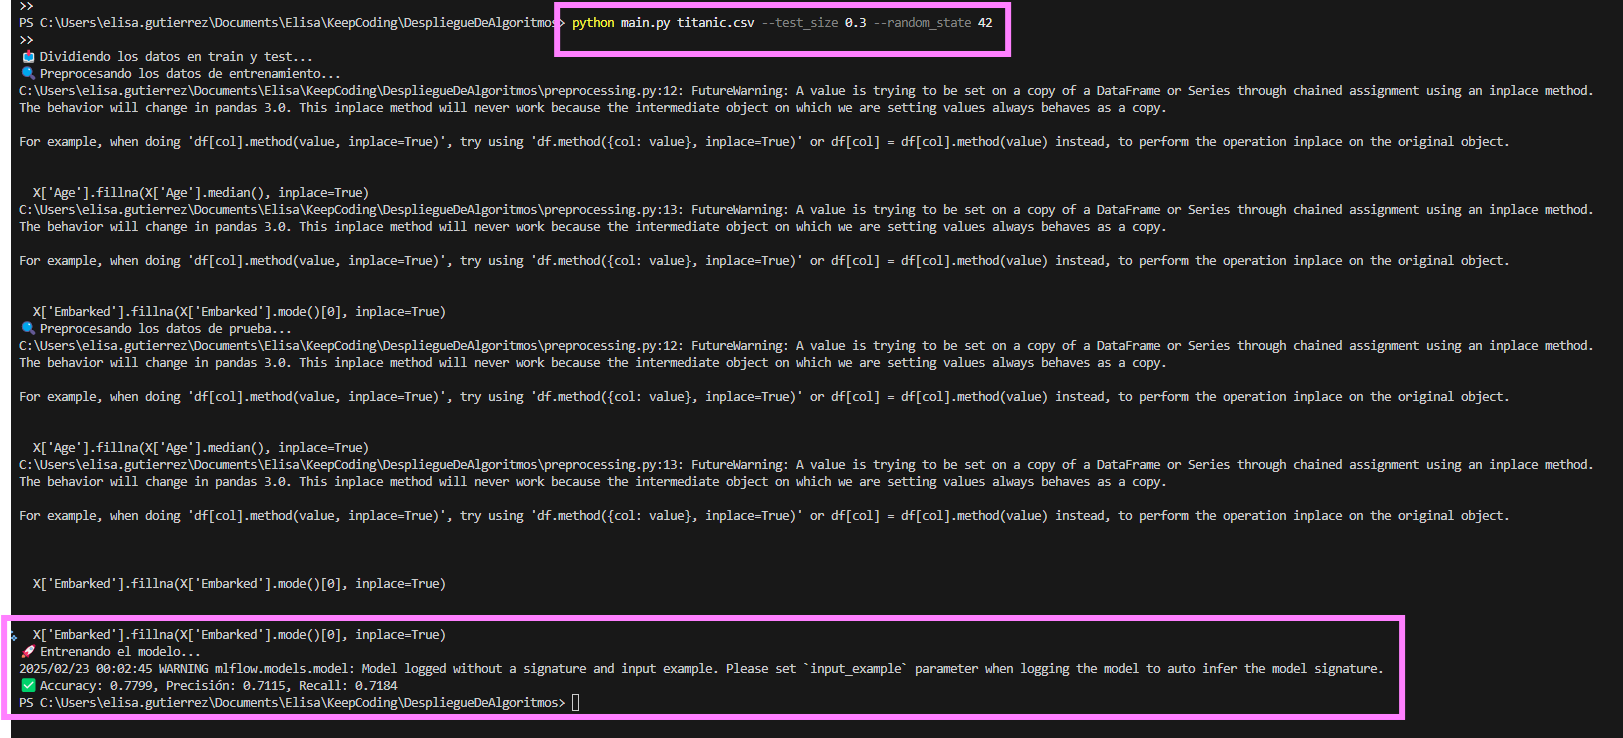

Podemos ver desde MLFLOW que aparece un nuevo experimento con los resultados de precisión, accuracy y recall, y con un valor de source distinto al de antes, ahora el source es main.py:

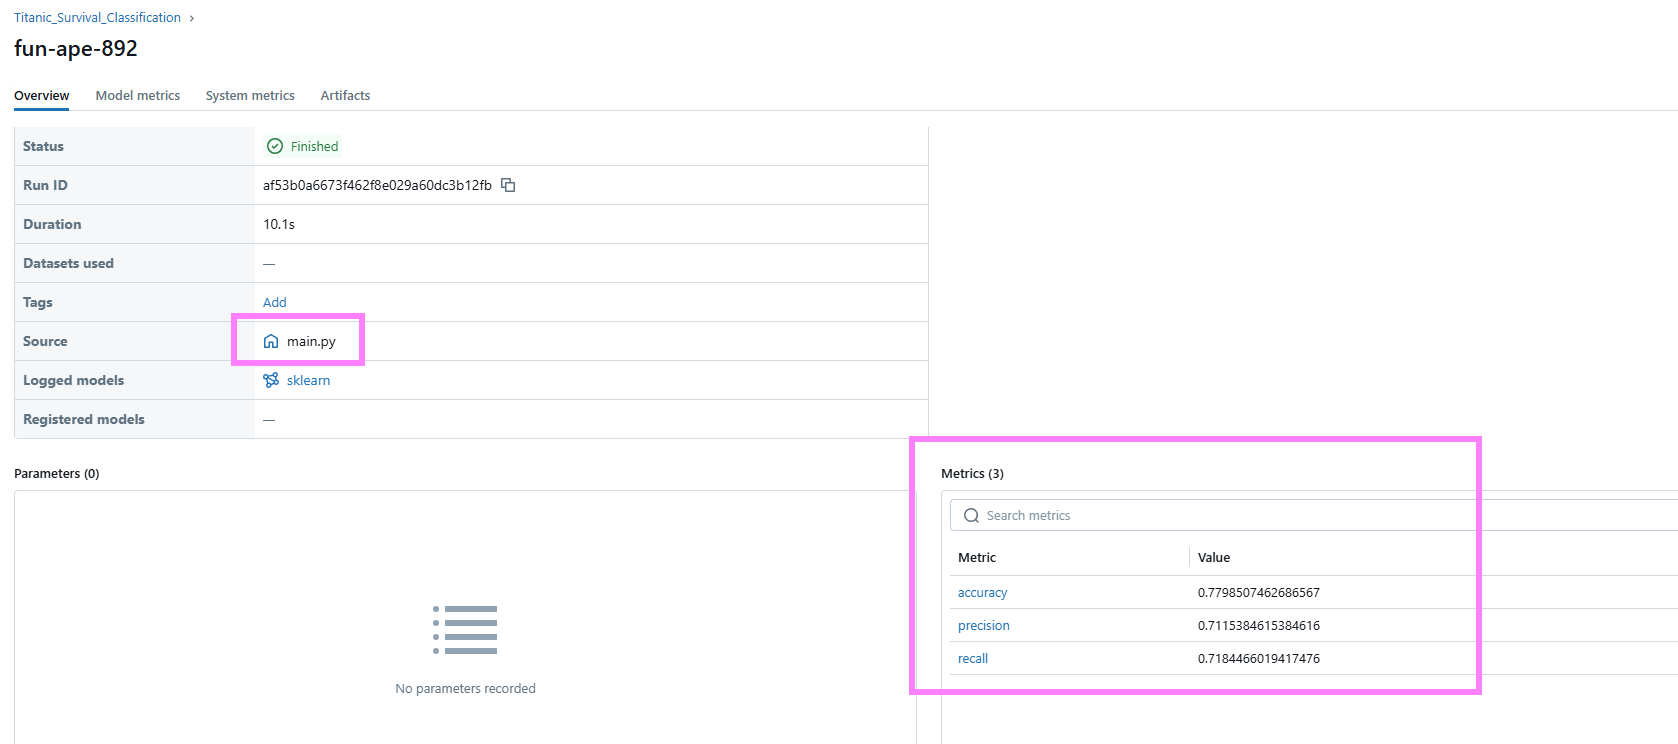

#### Comparación resultados
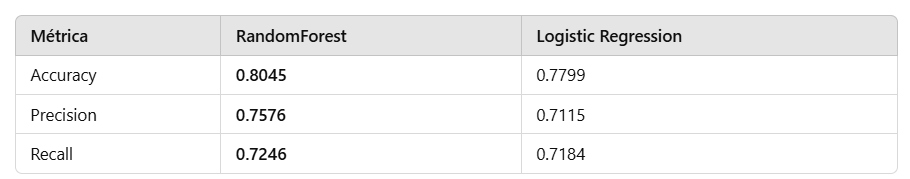

Comparando las métricas obtenidas, podemos concluir que RandomForest es mejor en todas las métricas: Tiene una mayor precisión, recall y accuracy.

## Práctica parte FastAPI

### Para esta parte de la práctica teneis que generar un script con al menos 5 modulos app.get y dos de ellos tienen que ser pipelines de HF. 

### Parte de la practica se tendra que entregar en capturas de pantalla. Las capturas de pantalla a adjuntas son las siguientes. 

### 1. Captura de la pantalla docs con al menos 5 modulos. 
### 2. Captura de cada una de los modulos con la respuesta dentro de docs. 
### 3. Captura de cada uno de los modulos en la llamada https.
### 4. Todo el codigo usado durante el proceso. Notebooks y scripts.

### Opcional

### 5. Despliegue del script en GCP Cloud Run

In [ ]:
!pip install transformers

from main_fastapi import FastAPI
from pydantic import BaseModel
import base64
import urllib
from typing import Optional
from transformers import pipeline

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [ ]:
%%writefile main_fastapi.py
from fastapi import FastAPI
from pydantic import BaseModel
import random
from transformers import pipeline

# Inicializar la app de FastAPI
app = FastAPI()

# Cargar modelos de Hugging Face
languageDetectionPipeline = pipeline("text-classification", model="papluca/xlm-roberta-base-language-detection")
spellingCorrectionPipeline = pipeline("text2text-generation", model="oliverguhr/spelling-correction-english")

# Modelo para la conversión de temperatura
class TemperatureConversion(BaseModel):
    value: float
    unit: str  # "C" para Celsius, "F" para Fahrenheit

# Modelo para corrección de texto
class TextCorrection(BaseModel):
    text: str

# Endpoint 1: Obtener un dato curioso aleatorio
@app.get("/dato_curioso")
def dato_curioso():
    datos = [
        "Los pulpos tienen tres corazones.",
        "Las abejas pueden reconocer rostros humanos.",
        "El agua caliente se congela más rápido que el agua fría.",
        "Los flamingos nacen con plumas grises, no rosadas.",
        "Los tiburones han existido por más de 400 millones de años.",
        "Tu cerebro genera suficiente electricidad para encender una bombilla pequeña",
        "Tus pulmones tienen una superficie total de aproximadamente el tamaño de una cancha de tenis",
        "Las uñas de las manos crecen más rápido que las de los pies"
    ]
    return {"dato_curioso": random.choice(datos)}

# Endpoint 2: Conversión de temperatura
@app.post("/convertir_temperatura")
def convertir_temperatura(temp: TemperatureConversion):
    if temp.unit.upper() == "C":
        resultado = (temp.value * 9/5) + 32
        return {"Fahrenheit": resultado}
    elif temp.unit.upper() == "F":
        resultado = (temp.value - 32) * 5/9
        return {"Celsius": resultado}
    else:
        return {"error": "Unidad no válida. Usa 'C' para Celsius o 'F' para Fahrenheit."}

# Endpoint 3 con HF: Detección de idioma
@app.post("/detectar_idioma")
def detectar_idioma(texto: TextCorrection):
    resultado = languageDetectionPipeline(texto.text)
    return {"idioma_detectado": resultado[0]['label']}

# Endpoint 4 con HF: Corrección ortográfica en inglés
@app.post("/corregir_texto")
def corregir_texto(texto: TextCorrection):
    resultado = spellingCorrectionPipeline(texto.text)
    return {"texto_corregido": resultado[0]["generated_text"]}

# Endpoint 5: Generación de nombres aleatorios a partir del género
@app.get("/generar_nombre")
def generar_nombre(genero: str):
    nombres_masculinos = ["Carlos", "Luis", "Andrés", "Fernando", "Juan", "José"]
    nombres_femeninos = ["María", "Elisa", "Carmen", "Isabel", "Ana", "Lucía"]
    
    if genero.lower() == "m":
        return {"nombre_generado": random.choice(nombres_masculinos)}
    elif genero.lower() == "f":
        return {"nombre_generado": random.choice(nombres_femeninos)}
    else:
        return {"error": "Género no válido. Usa 'masculino' o 'femenino'."}


Overwriting main_fastapi.py


In [ ]:
!pip install tensorflow==2.15.0 keras==2.15.0
!pip install transformers 
!pip install torch

  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
   ---------------------------------------- 0.0/300.9 MB ? eta -:--:--
   ---------------------------------------- 2.4/300.9 MB 9.6 MB/s eta 0:00:32
    --------------------------------------- 4.2/300.9 MB 9.3 MB/s eta 0:00:32
    --------------------------------------- 6.3/300.9 MB 9.6 MB/s eta 0:00:31
   - -------------------------------------- 7.9/300.9 MB 9.0 MB/s eta 0:00:33
   - -------------------------------------- 8.4/300.9 MB 9.1 MB/s eta 0:00:33
   - -------------------------------------- 9.4/300.9 MB 7.3 MB/s eta 0:00:41
   - -------------------------------------- 11.5/300.9 MB 7.6 MB/s eta 0:00:39
   - -------------------------------------- 13.4/300.9 MB 7.8 MB/s eta 0:00:38
   -- ------------------------------------- 15.2/300.9 MB 7.8 MB/s eta 0:00:37
   -- ------------------------------------- 16.8/300.9 MB 7.8 MB/s eta 0:00:37
   -- ------------------------

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.


  Using cached transformers-4.49.0-py3-none-any.whl.metadata (44 kB)
Using cached transformers-4.49.0-py3-none-any.whl (10.0 MB)


In [ ]:
from transformers import pipeline

Una vez está creada la API, podemos con el siguiente comando ejecutar la API en local ejecutando el script main_fastapi.py:
```bash
fastapi dev main_fastapi.py
```

El resultado es el siguiente:

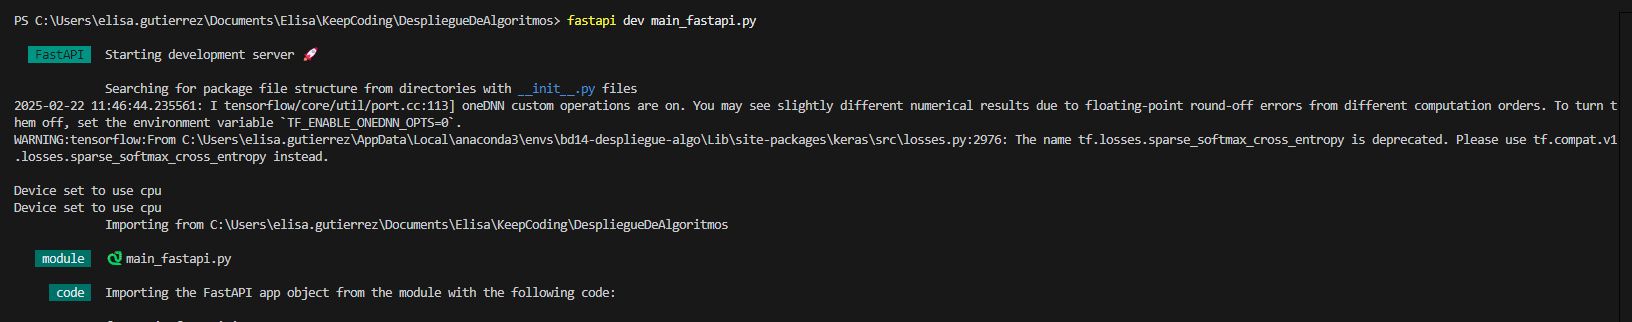
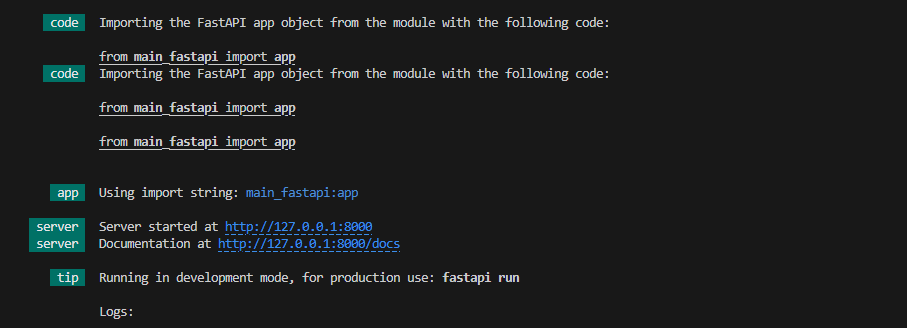

Ahora, podemos acceder a la URL que nos proporciona, y vemos que se nos abre Swagger. Desde esta herramienta, podemos probar cada uno de nuestros métodos.
A continuación, se muestra el resultado de probar cada operación:

*  Swagger con todos los endpoints de nuestra API disponibles:
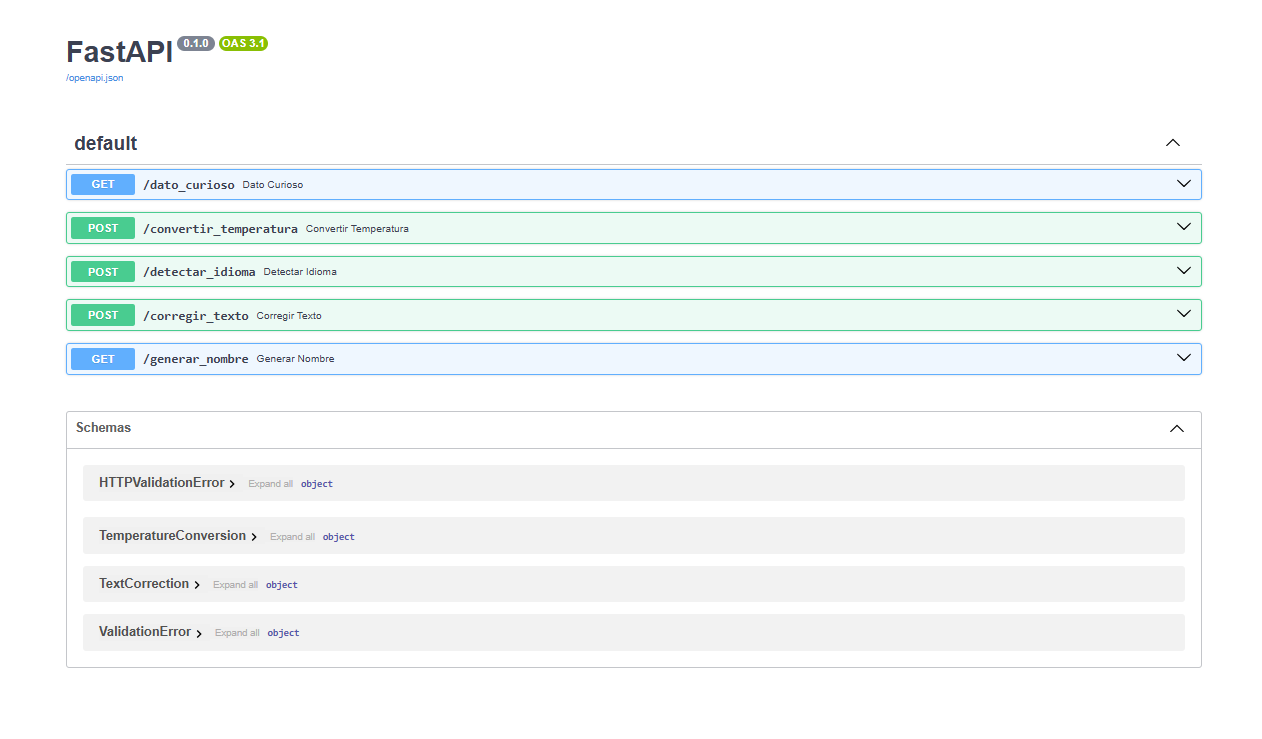

*  Endpoint 1:

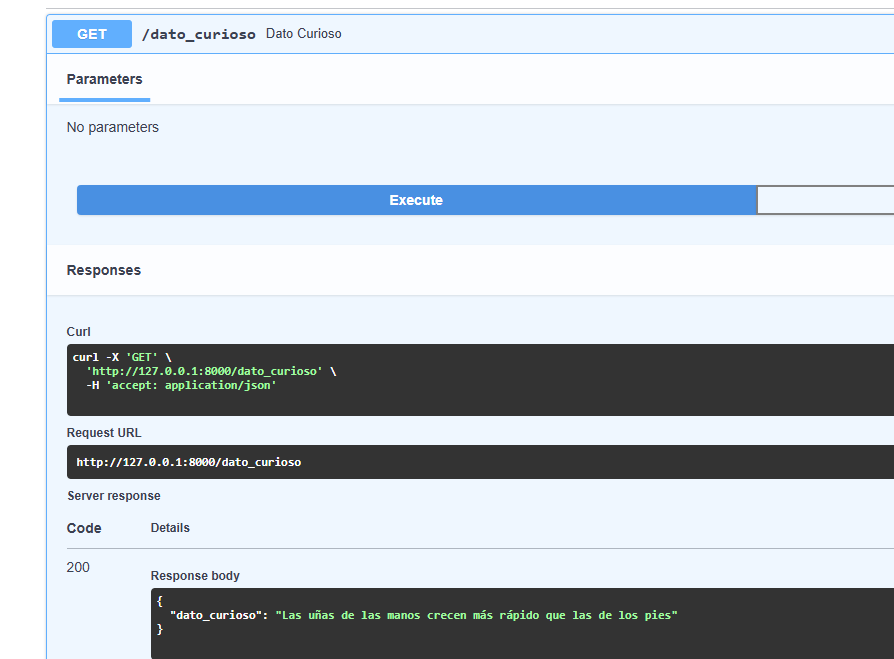

*  Endpoint 2:

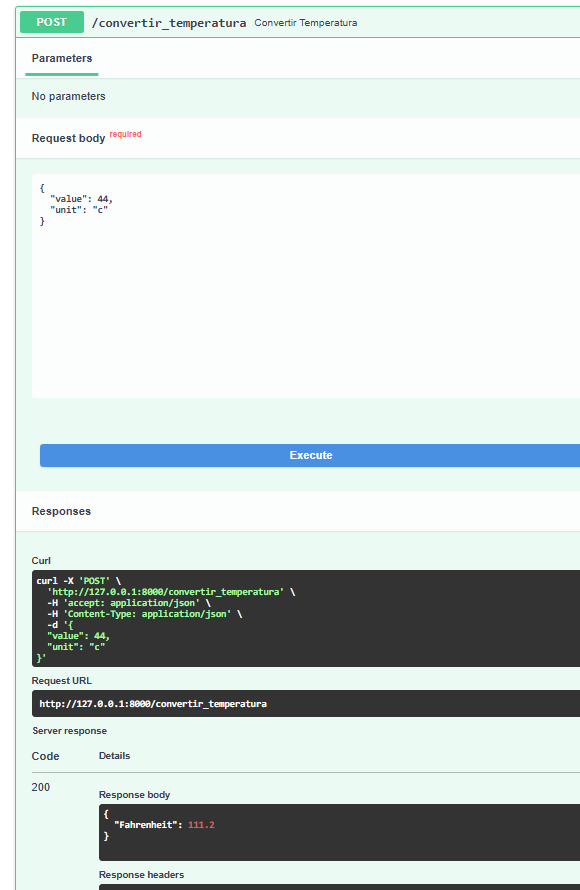
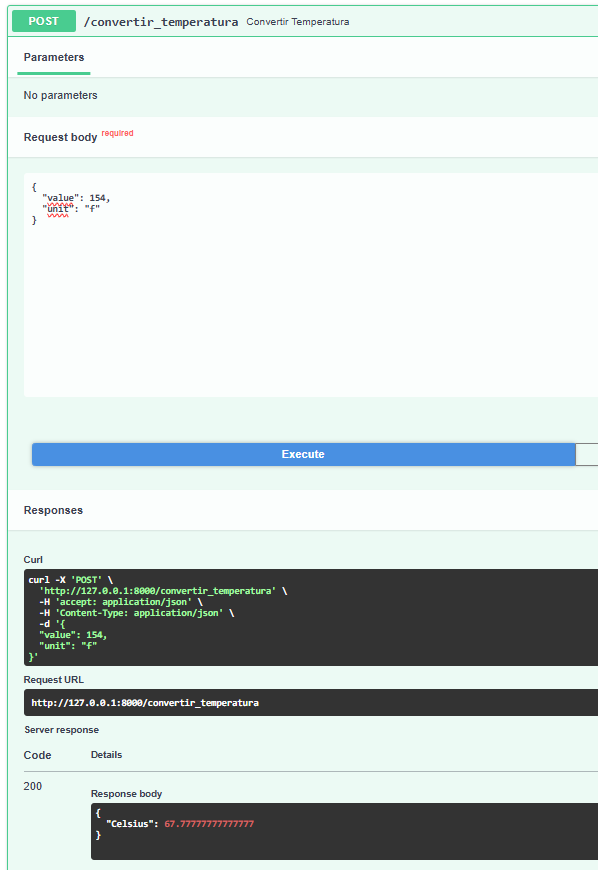

*  Endpoint 3:

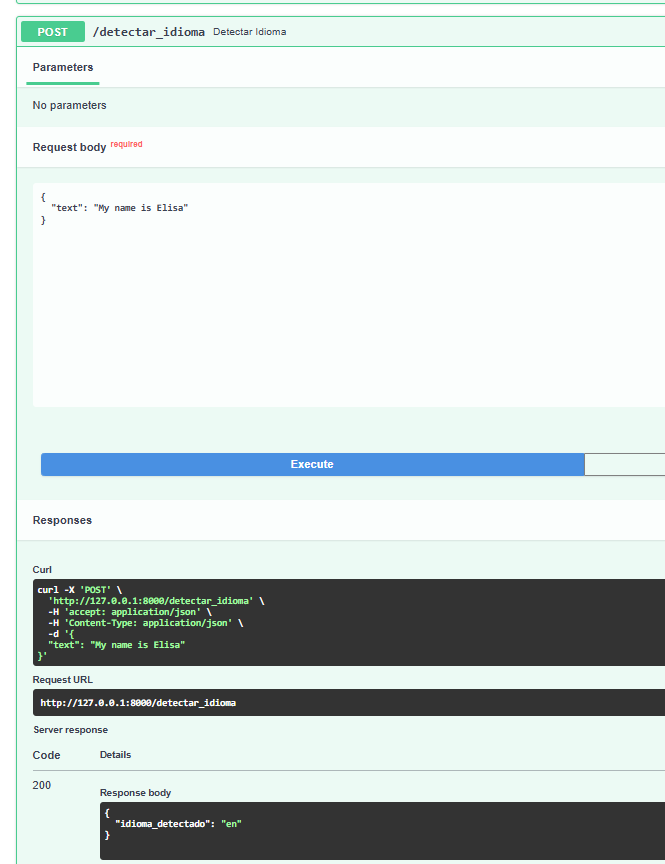
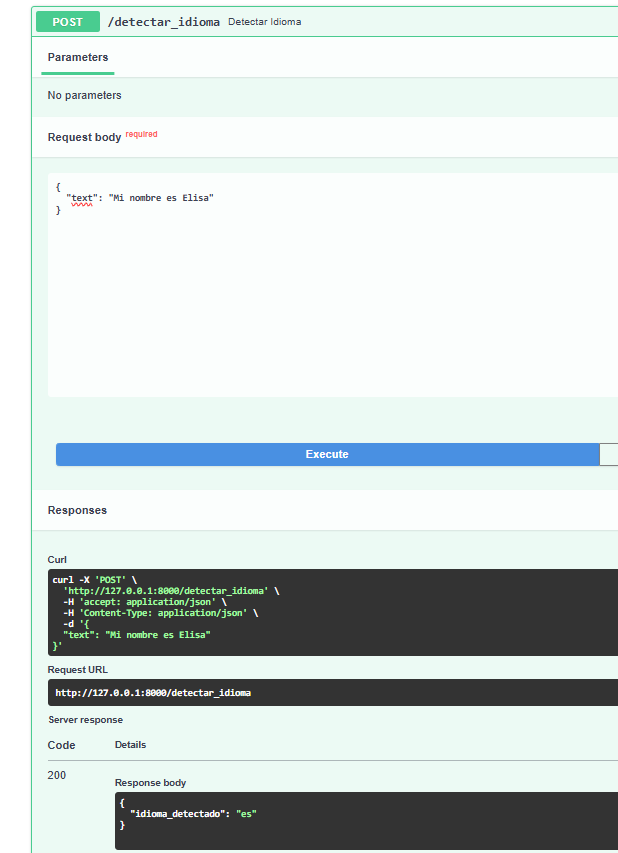

*  Endpoint 4:

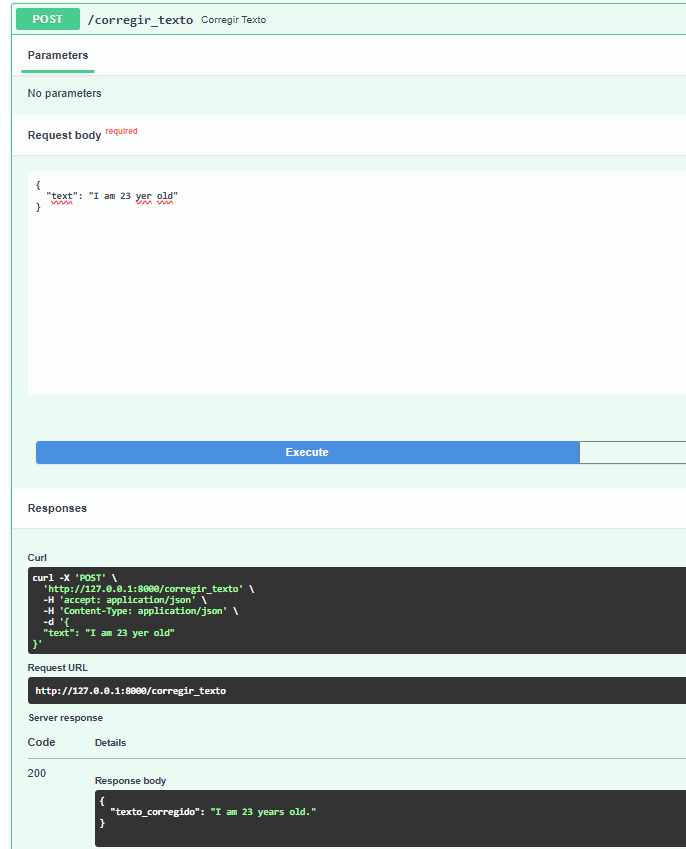

*  Endpoint 5:

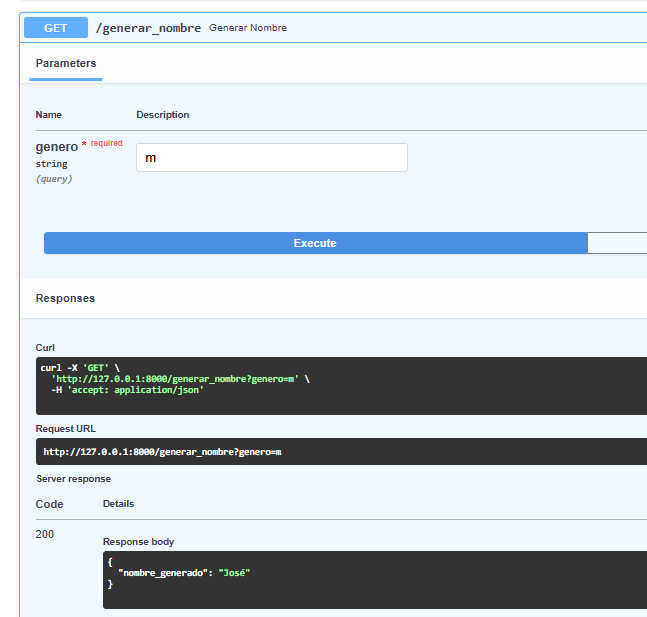
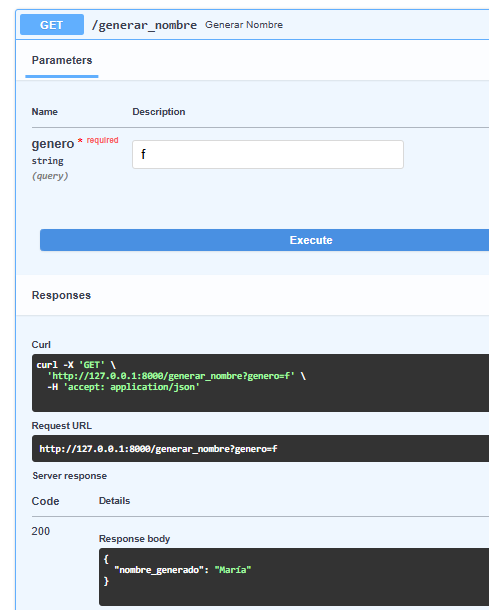

También podemos hacer uso de los endpoints de esta API desde python, como en el siguiente ejemplo, donde llamamos al endpoint con una llamada HTTTs al endpoint encargado de generar un nombre a partir del género que se manda por parámetro:

In [ ]:
import requests

url = "http://127.0.0.1:8000/generar_nombre?genero=f"

response = requests.get(url)

response.content

b'{"nombre_generado":"Isabel"}'